### ME 574 Winter 2019 Homework 2  
Solution by Jingyuan Liu

**1) Write python code to compute and print machine $\epsilon$ (for CPU computations). Take the following approach: Write a ```for()``` loop to compute $\epsilon_n = 0.5^n$ for increasing integer values of $n$ up to a default limit of ```N_MAX = 100```. When $1. == 1. + \epsilon_n$, store the values of $n$ and $\epsilon_n$ terminate the computation.**

In [1]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
for i in range(101):
    epsilon = 0.5**i
    if 1. == (1.+epsilon):
        print(i, epsilon)
        break

53 1.1102230246251565e-16


**2) This is the parallelized version of problem 1. Write  the following python code using ```numba```:  
a) Write a device function to compute $0.5^n$.**

In [5]:
@cuda.jit(device=True)
def power_of_half(n):
    return 0.5**n

**b) Write a kernel function that computes a `numpy` array of powers of $0.5$ by calling your device function.**

In [6]:
@cuda.jit
def kernel(d_out, d_n):
    size = d_n.size
    i = cuda.grid(1)
    if i < size:
        d_out[i] = power_of_half(d_n[i])

**c) Write a wrapper function to set up and launch the kernel**

In [7]:
def wrapper(n):
    d_n = cuda.to_device(n)
    d_out = cuda.device_array(n.size)
    TPB = 32
    BPG = (n.size-1)//TPB + 1
    kernel[BPG, TPB](d_out, d_n)
    return d_out.copy_to_host()

**d) Write a ```main()``` function that creates the ```numpy``` array, calls the wrapper function, and determines (and prints) the index and value corresponding to machine $\epsilon$.**

In [8]:
def main():
    n = np.arange(101) # array of n
    out = wrapper(n)
    for i, epsilon in enumerate(out):
        if 1. == (1.+epsilon):
            print(i, epsilon)
            break

**e) Execute your ```main()``` function to produce a value of machine $\epsilon$ computed on the GPU.**

In [9]:
main()

53 1.1102230246251565e-16


**f) Modify your code (specifically the definition of your ```numpy``` array using the optional ```dtype``` argument) to use 32-bit data (instead of 64-bit) floating point numbers. Re-execute ```main()``` and discuss how the new 32-bit result compares withe 64-bit version.**

If we only use 32-bit for the epsilon array `d_out`:

In [10]:
def wrapper(n):
    d_n = cuda.to_device(n)
    d_out = cuda.device_array(n.size, dtype=np.float32)
    TPB = 32
    BPG = (n.size-1)//TPB + 1
    kernel[BPG, TPB](d_out, d_n)
    return d_out.copy_to_host()

In [11]:
main()

53 1.110223e-16


The result is still $n = 53$. However, as for $\epsilon$, the first couple digits are the same, but the number of accurate digits is obviously less than before. This is due to the limited range a single precision number can represent.

If we further use 32-bit for the $1.$:

In [12]:
def main():
    n = np.arange(101) # array of n
    out = wrapper(n)
    one = np.array([1.], dtype=np.float32)
    for i, epsilon in enumerate(out):
        if one[0] == (one[0]+epsilon):
            print(i, epsilon)
            break

In [13]:
main()

24 5.9604645e-08


We see that both $n$ and $\epsilon$ have changed. The reason is the same as stated above, the range limit of single precision compared to double.

**g) Modify your code so that the test for identifying the exponent & value and the print statement are done in parallel in the kernel function. Discuss the order in which results are printed.**

In [29]:
@cuda.jit
def kernel(d_n):
    size = d_n.size
    i = cuda.grid(1)
    if i < size:
        epsilon = power_of_half(d_n[i])
        if 1. == (1.+epsilon):
            print(i, epsilon)

In [30]:
def wrapper(n):
    d_n = cuda.to_device(n)
    TPB = 32
    BPG = (n.size-1)//TPB + 1
    kernel[BPG, TPB](d_n)

In [31]:
def main():
    n = np.arange(101) # array of n
    wrapper(n)

In [33]:
main()

The printed results: (have line break in console)  
96 0.000000
97 0.000000
98 0.000000
99 0.000000
100 0.000000
53 0.000000
54 0.000000
55 0.000000
56 0.000000
57 0.000000
58 0.000000
59 0.000000
60 0.000000
61 0.000000
62 0.000000
63 0.000000
64 0.000000
65 0.000000
66 0.000000
67 0.000000
68 0.000000
69 0.000000
70 0.000000
71 0.000000
72 0.000000
73 0.000000
74 0.000000
75 0.000000
76 0.000000
77 0.000000
78 0.000000
79 0.000000
80 0.000000
81 0.000000
82 0.000000
83 0.000000
84 0.000000
85 0.000000
86 0.000000
87 0.000000
88 0.000000
89 0.000000
90 0.000000
91 0.000000
92 0.000000
93 0.000000
94 0.000000
95 0.000000

The results are not printed in monotonic order of $n$, as all threads are parallel and have no specific order when running.

However, I run multiple times and find that the output is the same every time. I change `TPB` and `BPG` and try to reproduce the random results demonstrated in class. I find that indices within one block seem always ordered, while the order is indeed random among different blocks. I think if this behavior is normal, it has to do with hardware structure and efficiency.

**h) THINK ABOUT THIS PART, BUT DO NOT DO IT. WE WILL RETURN TO THIS ISSUE LATER... Finally modify your code from part f so the kernel saves the exponent and value to named variables, and the ouput is a single line giving the exponent and value corresponding to machine $\epsilon$.**

**3) This problem deals with the difference equation corresponding to Newton's method applied to the function $f(x) = x (x^2-1)$.  
a) Determine the difference equation (you can do this by hand) and write a python function that takes an initial value of $x_n$ and computes the next iterate $x_{n+1}$.**

We use first order approximation from Taylor Series $$f(x_{n+1}) \approx f(x_n) + f'(x_n)(x_{n+1}-x_n)$$  
We want $f(x_{n+1}) = 0$, so we get $$0 = f(x_n) + f'(x_n)(x_{n+1}-x_n)$$  
which then gives us $$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$  
In this case where $f(x) = x (x^2-1)$,  we have $$x_{n+1} = x_n - \frac{x_n^3-x_n}{3x_n^2-1}$$

In [34]:
def newton_one_iter(x):
    return x - (x**3-x)/(3*x**2-1)

**b) Write python code using a ```for()``` loop to compute a sequence of iterates subject to termination criteria including a desired tolerance and a maximum iteration count.**

In [52]:
def newton(x0, tol, max_iter):
    x1 = 0
    for i in range(max_iter):
        x1 = newton_one_iter(x0)
        if np.abs(x1-x0) < tol:
            break
        x0 = x1
    return x1

**c) Choose a few initial values and compute/plot the sequence of iterates. Illustrate each of the following cases:**

    i) Convergence to x= -1.

    ii) Convergence to x= 0.

    iii) Convergence to x= 1.

    iv) Convince yourself that there is bounded but non-convergent behavior by finding a fixed point where $g(g(x)) = x$ but $g(x) \neq x$. Find the relevant value(s) of $x$. Can you observe this behavior using your numerical iteration code? Why or why not?  

In [53]:
initials = np.linspace(-5 ,5, 100)
tol = 1e-6
max_iter = 100

results = np.empty(initials.size)
for i, x0 in enumerate(initials):
    results[i] = newton(x0, tol, max_iter)

Text(0, 0.5, 'convergence value')

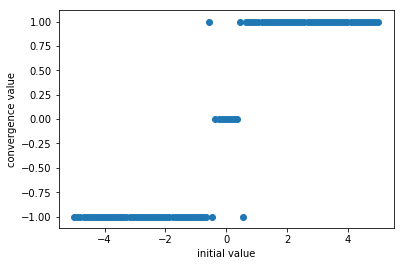

In [55]:
plt.scatter(initials, results)
plt.xlabel('initial value')
plt.ylabel('convergence value')

From the plot we can clearly see that initial values near 0 converges to 0, while initial values smaller than around -0.5 converges to -1, and initial values larger than around 0.5 converges to 1.

For the last question, we try to visualize the output values after 0(initial), 1, 2 newton method iteration:

In [56]:
one_iter = np.empty(initials.size)
two_iter = np.empty(initials.size)
for i, x0 in enumerate(initials):
    one_iter[i] = newton_one_iter(x0)
    two_iter[i] = newton_one_iter(one_iter[i])

Text(0, 0.5, 'output value')

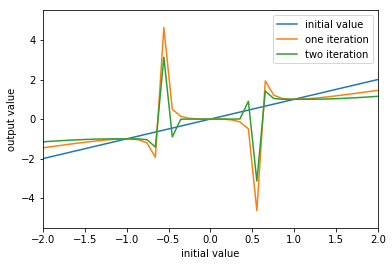

In [63]:
plt.plot(initials, initials, label='initial value')
plt.plot(initials, one_iter, label='one iteration')
plt.plot(initials, two_iter, label='two iteration')
plt.xlim(-2, 2)
plt.legend()
plt.xlabel('initial value')
plt.ylabel('output value')

We can see from the plot that there are 4 initial values around -0.5 and 0.5, where the output of double iteration is the same as the initial value but different from the output of single iteration. This means these 4 initial values show periodic behaviors, as they come back to the initial values every two iterations, which are bounded but non-convergent behavior.

**4) Parallelize your code from Problem 3 using ```numba``` as follows:**

    a) Convert your function to a device function.
    
    b) Instead of using a loop, launch a kernel function and store your results in a device array.
    
    c) Copy the array back to the host and check that it coincides with the serial version.
    
    d) Plot the results and the difference between the serial and parallel versions.

In [70]:
@cuda.jit(device=True)
def d_newton(x0, tol, max_iter):
    x1 = 0
    for i in range(max_iter):
        x1 = x0 - (x0**3-x0)/(3*x0**2-1)
        if abs(x1-x0) < tol:
            break
        x0 = x1
    return x1

In [71]:
@cuda.jit
def kernel(d_out, d_initials, tol, max_iter):
    size = d_initials.size
    i = cuda.grid(1)
    if i < size:
        d_out[i] = d_newton(d_initials[i], tol, max_iter)

In [72]:
N = initials.size
TPB = 32
BPG = (N-1)//TPB + 1
d_out = cuda.device_array(initials.size)
kernel[BPG, TPB](d_out, cuda.to_device(initials), tol, max_iter)
out = d_out.copy_to_host()

We check and find that the paralleled results coincides with the serial results:

In [75]:
np.max(np.abs(out-results))

0.0

Plot the paralleled results:

Text(0, 0.5, 'convergence value')

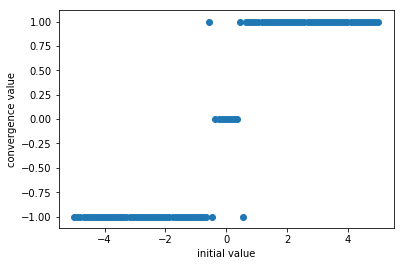

In [77]:
plt.scatter(initials, out)
plt.xlabel('initial value')
plt.ylabel('convergence value')

Plot the difference between the serial and parallel results:

Text(0, 0.5, 'difference between serial and parallel results')

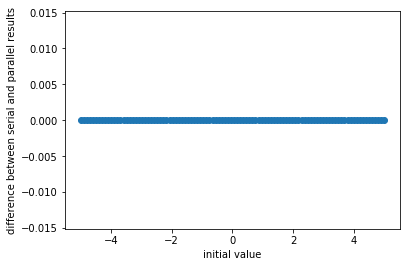

In [79]:
plt.scatter(initials, out-results)
plt.xlabel('initial value')
plt.ylabel('difference between serial and parallel results')

**5) Shorghofer problem 4.5 which corresponds to Newton's method applied to the complex function $f(z) = z^3 - 1$. Again, obtain the difference equation by hand and rewrite it as a pair of difference equations (or a difference equation for a vector of length 2 with real components $x$ and $y$). The notebook you submit should include both code for a serial implementation using nested ```for()``` loops and the requested plot**

Simplify the complex iteration

\begin{align}
x'+y'j &= x+yj - \frac{(x+yj)^3-1}{3(x+yj)^2} \\
&= x+yj - \frac{(x+yj)(x^2-y^2+2xyj)-1}{3(x^2-y^2+2xyj)} \\
&= x+yj - \frac{(x^3-3xy^2-1)+(3x^2y-y^3)j}{3(x^2-y^2)+6xyj} \\
&= x+yj - \frac{a+bj}{c+dj}
\end{align}

Then we can write two iterations for real and imaginary part

\begin{align}
x' = x - \frac{ac+bd}{c^2+d^2} \\
y' = y - \frac{bc+ad}{c^2+d^2}
\end{align}

Notice:  
1) There can me numerical problem when $c^2+d^2 \to 0$. We avoid this problem by stopping the iteration and return to the previous position.  
2) The requested resolution (0.002) requires too much memory for my GPU card. I choose a larger resolution 0.004 instead, yet the plots still show good quality and the behavior we want.  
3) We use `pyplot.imshow()` for plotting. We have to manipulate the result matrix and the plot to produce a normal-looking complex plane.

In [2]:
def complex_newton(x, y):
    for i in range(2000):
        a = x**3-3*x*y**2 - 1
        b = 3*x**2*y - y**3
        c = 3 * (x**2-y**2)
        d = 6 * x * y
        de = c**2 + d**2
        if de == 0:
            break
        else:
            x = x - (a*c+b*d) / de
            y = y - (b*c-a*d) / de
    return x, y

In [3]:
N = 501
axis = np.linspace(-1, 1, N)
tol = 1e-6
x = np.empty((N, N))
y = np.empty((N, N))
for i in range(N):
    for j in range(N):
        x1, y1 = complex_newton(axis[i], axis[j])
        x[i, j] = x1
        y[i, j] = y1

Text(0, 0.5, 'imaginary axis')

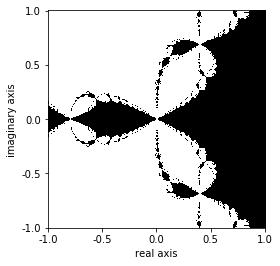

In [4]:
grid = (np.square(1-x)+np.square(y)) < tol
plt.imshow((1-grid).T, cmap='gray')
plt.xticks(np.linspace(0, N-1, 5), np.linspace(-1, 1, 5))
plt.yticks(np.linspace(0, N-1, 5), np.linspace(-1, 1, 5))
plt.gca().invert_yaxis()
plt.xlabel('real axis')
plt.ylabel('imaginary axis')

**6) Parallelize your code from Problem 5 using ```numba``` by converting your iteration to a device function and replacing the nested loops with a kernel function that launches a 2D computational grid. Test whether the 2D array of values produced by the kernel agress with the serial version. Present (briefly discuss) the results of the comparison of serial and parallel results.**

In [5]:
@cuda.jit(device=True)
def d_complex_newton_one_iter(x, y):
    a = x**3-3*x*y**2 - 1
    b = 3*x**2*y - y**3
    c = 3 * (x**2-y**2)
    d = 6 * x * y
    de = c**2 + d**2
    if de == 0:
        return x, y
    else:
        x = x - (a*c+b*d) / de
        y = y - (b*c-a*d) / de
        return x, y

In [6]:
@cuda.jit
def complex_newton_kernel(d_axis, d_out_x, d_out_y):
    N = d_axis.size
    i, j = cuda.grid(2)
    if i < N and j < N:
        x0, y0 = d_axis[i], d_axis[j]
        for t in range(2000):
            x0, y0 = d_complex_newton_one_iter(x0, y0)
        d_out_x[i, j] = x0
        d_out_y[i, j] = y0

In [7]:
TPB = 32
BPG = (N-1)//TPB + 1
d_out_x = cuda.device_array((N, N))
d_out_y = cuda.device_array((N, N))
complex_newton_kernel[(BPG, BPG), (TPB, TPB)](cuda.to_device(axis), d_out_x, d_out_y)
out_x = d_out_x.copy_to_host()
out_y = d_out_y.copy_to_host()

We compare the parallel results and the serial results. We can see below that the maximum difference is around machine precision, which means the two results are acceptably the same.

In [8]:
# compare
print(np.max(np.abs(out_x-x)))
print(np.max(np.abs(out_y-y)))

0.0
1.1102230246251565e-16


Text(0, 0.5, 'imaginary axis')

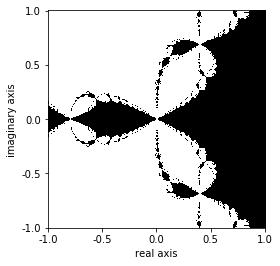

In [9]:
grid = (np.square(1-out_x)+np.square(out_y)) < tol
plt.imshow((1-grid).T, cmap='gray')
plt.xticks(np.linspace(0, N-1, 5), np.linspace(-1, 1, 5))
plt.yticks(np.linspace(0, N-1, 5), np.linspace(-1, 1, 5))
plt.gca().invert_yaxis()
plt.xlabel('real axis')
plt.ylabel('imaginary axis')